In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from imutils import paths
from sklearn.manifold import TSNE
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model, Model
from utils import weighted_categorical_crossentropy, grad_cam, save_and_display_gradcam

import warnings
warnings.filterwarnings('ignore')

## FiSHNet

In [2]:
## !sudo apt-get install graphviz

model = load_model('./otolith.model', custom_objects={"loss_fn": weighted_categorical_crossentropy})
plot_model(model, to_file='./Figs/Figure_S1_FiSHNet_architecture.png', show_shapes=False, show_layer_names=True, dpi=600)

2025-02-11 04:43:01.437880: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-11 04:43:02.039051: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22028 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:a8:00.0, compute capability: 8.9


## t-SNE

2025-02-11 04:43:09.087651: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101
2025-02-11 04:43:10.194468: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2025-02-11 04:43:10.194491: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2025-02-11 04:43:10.194559: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2025-02-11 04:43:10.567280: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


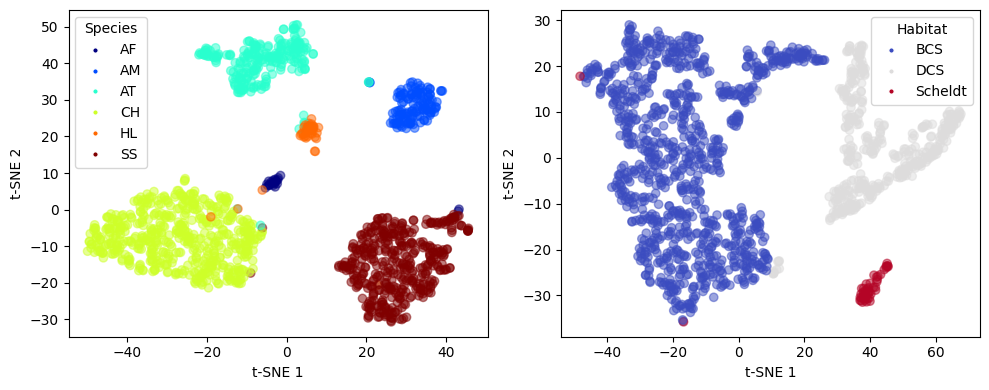

In [3]:
# Extract features from dense_1 and dense_3 layers
species_layer = model.get_layer('dense_1')  # Last dense layer for species classification
habitat_layer = model.get_layer('dense_3')  # Last dense layer for habitat classification

# Create a new model with outputs from dense_1 and dense_3
feature_model = Model(inputs=model.input, outputs=[species_layer.output, habitat_layer.output])

# Define image paths
imagePaths = sorted(list(paths.list_images("otolith_dataset")))

# Lists to store extracted features for species and habitat
species_features = []
habitat_features = []

# Process each image and extract features
for imagePath in imagePaths:
    img_path = imagePath
    image = cv2.imread(img_path)
    image = cv2.resize(image, (256, 256))  # Resize to match model input
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    image = image.astype("float32") / 255.0  # Normalize

    # Get features from dense_1 and dense_3 layers
    species_feature, habitat_feature = feature_model.predict(image)
    
    # Append features to lists
    species_features.append(species_feature)
    habitat_features.append(habitat_feature)

# Convert lists to numpy arrays
species_features = np.array(species_features).squeeze()  # (n_samples, 6) for species
habitat_features = np.array(habitat_features).squeeze()  # (n_samples, 4) for habitat

# Perform t-SNE dimensionality reduction separately for species and habitat
tsne_species = TSNE(n_components=2, random_state=42)
tsne_habitat = TSNE(n_components=2, random_state=42)

species_tsne = tsne_species.fit_transform(species_features)  # t-SNE for species
habitat_tsne = tsne_habitat.fit_transform(habitat_features)  # t-SNE for habitat

# Define labels for species and habitat
species_labels = ['AF', 'AM', 'AT', 'CH', 'HL', 'SS']
habitat_labels = ['BCS', 'DCS', 'Scheldt']

# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Plot t-SNE results for species
scatter1 = ax[0].scatter(species_tsne[:, 0], species_tsne[:, 1], c=np.argmax(species_features, axis=1), cmap='jet', alpha=0.5)
ax[0].set_xlabel('t-SNE 1', fontsize=14)
ax[0].set_ylabel('t-SNE 2', fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)

# Create a legend for species classes
handles1 = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter1.cmap(scatter1.norm(i)), markersize=4) 
            for i in range(len(species_labels))]
ax[0].legend(handles1, species_labels, title="Species", loc='best', fontsize=10)


# Plot t-SNE results for habitat
scatter2 = ax[1].scatter(habitat_tsne[:, 0], habitat_tsne[:, 1], c=np.argmax(habitat_features, axis=1), cmap='coolwarm', alpha=0.5)
ax[1].set_xlabel('t-SNE 1', fontsize=14)
ax[1].set_ylabel('t-SNE 2', fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)

# Create a legend for habitat classes
handles2 = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter2.cmap(scatter2.norm(i)), markersize=4) 
            for i in range(len(habitat_labels))]
ax[1].legend(handles2, habitat_labels, title="Habitat", loc='best', fontsize=10)

plt.tight_layout()
fig.savefig('./Figs/Figure_2_t-SNE.png', dpi=600, bbox_inches='tight')

## Grad-CAM

In [4]:
imagePaths_exp = sorted(list(paths.list_images("otolith_examples")))

for imagePath in imagePaths_exp:
    img_path = imagePath
    image = cv2.imread(img_path)
    image = cv2.resize(image, (256, 256))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = np.expand_dims(image, axis=0) 
    image = image.astype("float32") / 255.0

    # Predict the species and habitat labels
    predictions = model.predict(image)
    species_pred = predictions[0]
    habitat_pred = predictions[1]

    # Get the class with the highest prediction probability for species and habitat
    species_class = np.argmax(species_pred)
    habitat_class = np.argmax(habitat_pred)

    # Generate Grad-CAM for the species classification branch
    species_heatmap = grad_cam(model, image, species_class, "conv2d_2")

    # Generate Grad-CAM for the habitat classification branch
    habitat_heatmap = grad_cam(model, image, habitat_class, "conv2d_5")
    
    # Save and display the Grad-CAM results for species classification
    save_and_display_gradcam(img_path, species_heatmap, cam_path="./otolith_examples/CAM_species/"+os.path.basename(imagePath))
    
    # Save and display the Grad-CAM results for habitat classification
    save_and_display_gradcam(img_path, habitat_heatmap, cam_path="./otolith_examples/CAM_habitat/"+os.path.basename(imagePath))

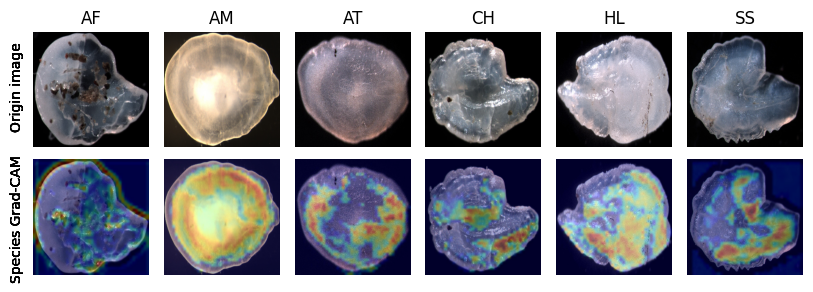

In [5]:
# Species branch Grad-CAM
imagePaths_exp_spe = sorted(list(paths.list_images("./otolith_examples/CAM_species/")))

fig, ax = plt.subplots(2, 6, figsize=(8, 3))
for idx, imagePath in enumerate(imagePaths_exp_spe):
    img_origin = cv2.resize(cv2.imread('./otolith_examples/Origin/'+os.path.basename(imagePath)), (256,256))
    ax[0, idx].imshow(cv2.cvtColor(img_origin, cv2.COLOR_BGR2RGB))
    ax[0, idx].axis('off')
    ax[0, idx].set_title(os.path.basename(imagePath).split('-')[0])

    img_cam_spe = cv2.resize(cv2.imread('./otolith_examples/CAM_species/'+os.path.basename(imagePath)), (256,256))
    ax[1, idx].imshow(cv2.cvtColor(img_cam_spe, cv2.COLOR_BGR2RGB))
    ax[1, idx].axis('off')
    
    fig.text(-0.01, 0.70, 'Origin image', va='center', rotation=90, fontsize=10)
    fig.text(-0.01, 0.26, 'Species Grad-CAM', va='center', rotation=90, fontsize=10)
    
plt.tight_layout()
plt.savefig('./Figs/Figure_3_1_Species_Grad-CAM.png', dpi=600, bbox_inches='tight')

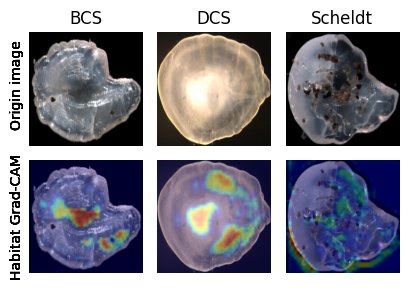

In [6]:
# Habitat branch Grad-CAM
imagePaths_exp_hab = sorted(list(paths.list_images("./otolith_examples/CAM_habitat/")))
jdx = 2

fig, ax = plt.subplots(2, 3, figsize=(4, 3))
for idx, imagePath in enumerate(imagePaths_exp_hab):
    if idx in [3, 1, 0]:
        img_origin = cv2.resize(cv2.imread('./otolith_examples/Origin/'+os.path.basename(imagePath)), (256,256))
        ax[0, jdx].imshow(cv2.cvtColor(img_origin, cv2.COLOR_BGR2RGB))
        ax[0, jdx].axis('off')
        ax[0, jdx].set_title(os.path.basename(imagePath).split('-')[1])

        img_cam_spe = cv2.resize(cv2.imread('./otolith_examples/CAM_habitat/'+os.path.basename(imagePath)), (256,256))
        ax[1, jdx].imshow(cv2.cvtColor(img_cam_spe, cv2.COLOR_BGR2RGB))
        ax[1, jdx].axis('off')
        jdx -= 1
    
    fig.text(-0.01, 0.70, 'Origin image', va='center', rotation=90, fontsize=10)
    fig.text(-0.01, 0.26, 'Habitat Grad-CAM', va='center', rotation=90, fontsize=10)
    
plt.tight_layout()
plt.savefig('./Figs/Figure_3_2_Habitat_Grad-CAM.png', dpi=600, bbox_inches='tight')